In [58]:
import importlib
import project_utils.deciles as deciles
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from general_utils import utils
from general_utils.OverallDetailComparisonPlot import OverallDetailComparisonPlot
import os
from matplotlib import colors as mcolors
import math
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

utils.default_plot_format()
utils.pd_display_settings(3)

In [59]:
data_path = r"processed_data\raw_metrics\processed_10min_Nabian.pkl"

In [60]:
pickled = pd.read_pickle(data_path)
data = pickled["data"]
indicator_columns = pickled["indicator_columns"]
time_metrics = pickled["time_metrics"]
frequency_metrics = pickled["frequency_metrics"]
non_linear_metrics = pickled["non_linear_metrics"]
data.tail()

indicator_columns.remove('D2')
non_linear_metrics.remove('D2')

In [61]:
median_melted = deciles.produce_median_melt(data, indicator_columns)

metrics = ['HF Power', 'SDRR', 'SD2', 'Mean HR (bpm)', 'LF Power', 'DFA α2', 'S',
       'RMSSD', 'SD1']

metrics = time_metrics
#median_melted = median_melted[median_melted["metric"].isin(metrics)]


median_pivot = median_melted.pivot(index=["id", "DPN"], columns="metric", values="value").reset_index()
print(median_pivot.columns)

Index(['id', 'DPN', 'ApEn', 'DFA α1', 'DFA α2', 'HF Peak Frequency',
       'HF Power', 'LF Peak Frequency', 'LF Power', 'LF÷HF Ratio',
       'Mean HR (bpm)', 'RMSSD', 'S', 'SD1', 'SD1÷SD2', 'SD2', 'SDRR',
       'SampEn', 'VLF Peak Frequency', 'VLF Power', 'pNN50 (%)'],
      dtype='object', name='metric')


In [62]:

clusters = 3
 
kmeans = KMeans(n_clusters = clusters)
kmeans.fit(median_pivot)
 
print(list(kmeans.labels_))
dpn = median_pivot["DPN"]

dpn = list(1 if val else 0 for val in dpn)
print(dpn)




[0, 1, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 2, 0, 2, 1, 0, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]


In [63]:

pca = PCA(3)
pca.fit(median_pivot)
 
pca_data = pd.DataFrame(pca.transform(median_pivot))
 
print(pca_data)

           0      1      2
0     703.28  21.72   4.06
1   -9300.75  21.22  -0.25
2    -748.30  16.44  -0.22
3  -11361.31  15.60 -10.02
4   -6864.78  19.55  -1.75
5      23034   7.65  10.41
6  -15419.58 -14.56  -7.40
7   -5285.82  12.71  11.99
8      24475  -4.98  -2.01
9   -4401.08  16.37 -10.53
10 -14359.11 -12.60  -1.47
11 -13385.26  -9.61   9.42
12 -15090.27  -9.68 -14.07
13  -9716.46  11.99 -10.74
14     10447  15.47 -35.22
15      5448   9.37  28.76
16     27939 -12.29   5.05
17  -8384.41   1.21   1.80
18   -543.70  10.03   7.11
19     35272 -21.22 -15.53
20      3578   4.00  11.78
21     29518 -14.95   0.19
22 -16571.13 -44.01   2.60
23   -935.96   1.09  17.96
24 -15990.00 -33.58   1.11
25 -12055.89  -6.94  -3.01


In [64]:
fig = go.Figure()

str_labels = [label for label in kmeans.labels_]
cluster_colors = {0: 'blue', 1: 'red'}
cluster_colors = dict(zip(range(clusters), cluster_colors.values()))

fig.add_trace(go.Scatter3d(
    x=pca_data[0],
    y=pca_data[1],
    z=pca_data[2],
    mode='markers+text',
    marker=dict(
        size=5,
        color=list(map(lambda label: cluster_colors[label], dpn)),
        opacity=0.8
    ),
    text=str_labels,
    textposition='top center'
))

fig.update_layout(
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3',
        aspectratio=dict(x=1, y=1, z=1),
        aspectmode='cube'
    ),
    width=600, height=500,
    margin=dict(l=10, r=10, b=10, t=10)
)

fig.show()


In [65]:
median_pivot = median_pivot.drop(columns=["id", "DPN"])

# LDA

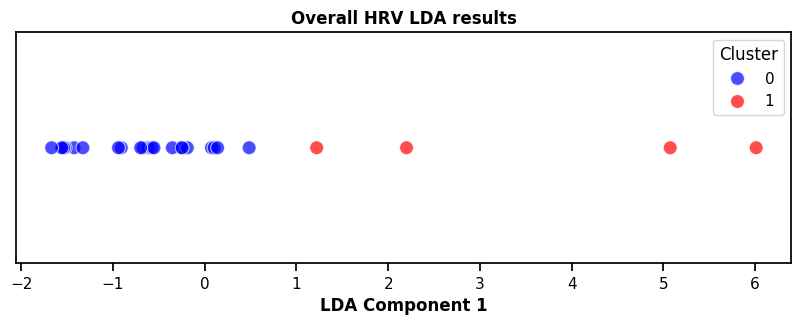

Explained variance ratio:  [1.]
Intercept:  [112.48833678]
Priors [0.84615385 0.15384615]


,Columns,LDA Coef,Means
0,SDRR,86.67,0.63
1,RMSSD,-34.18,0.29
2,pNN50 (%),-9.01,0.34
3,Mean HR (bpm),6.24,0.62
4,VLF Power,6.68,0.53
5,VLF Peak Frequency,-43.45,0.71
6,LF Power,-12.79,0.20
7,LF Peak Frequency,147.18,0.22
8,HF Power,-6.17,0.57
9,HF Peak Frequency,43.28,0.49


In [114]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
import matplotlib.pyplot as plt

def perform_lda(data, target, columns = None, n_components=1):
    if columns is not None:
        data = data[columns]
    
    data = (data - data.min()) / (data.max() - data.min())
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    lda_data = lda.fit_transform(data, target)
    lda_df = pd.DataFrame(lda_data)
    lda_df['Cluster'] = target

   # print(dir(lda_data))
    return lda_df, lda


def plot_lda_results(lda_df, dpn, title = 'LDA Results'):
    plt.figure(figsize=(10, 3))
    sns.scatterplot(x=lda_df[0], y=[0] * len(lda_df), hue=lda_df['Cluster'], palette=cluster_colors, s=100, alpha=0.7)
    plt.yticks([])
    plt.xlabel('LDA Component 1')
    plt.title(title)
    plt.show()

def show_lda_stats(lda, columns):
    print("Explained variance ratio: ", lda.explained_variance_ratio_)
    print("Intercept: ", lda.intercept_)
    print("Priors", lda.priors_)

    df = pd.DataFrame({
        'Columns': columns,
        'LDA Coef': lda.coef_[0],
        'Means': lda.means_[0],
    })
    display(df)




lda_df, lda = perform_lda(median_pivot, dpn)
plot_lda_results(lda_df, dpn, "Overall HRV LDA results")
show_lda_stats(lda, indicator_columns)

LDA allows to isolate all of the DPN patients by over-fitting.

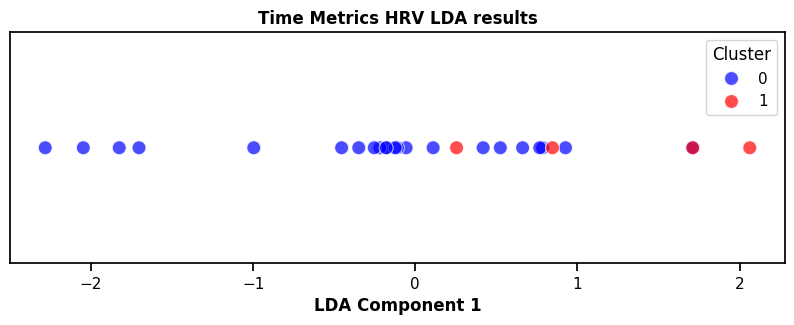

Explained variance ratio:  [1.]
Intercept:  [-1.22859992]
Priors [0.84615385 0.15384615]


,Columns,LDA Coef,Means
0,SDRR,-12.14,0.50
1,RMSSD,5.78,0.49
2,pNN50 (%),2.85,0.23
3,Mean HR (bpm),1.91,0.57


In [115]:
lda_df, lda = perform_lda(median_pivot, dpn, columns=time_metrics)
plot_lda_results(lda_df, dpn, "Time Metrics HRV LDA results")
show_lda_stats(lda, time_metrics)

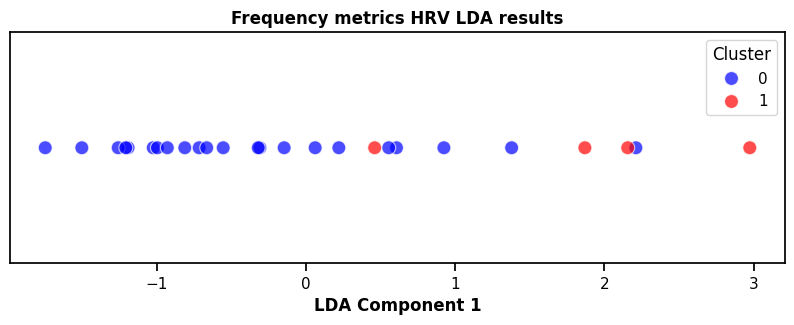

Explained variance ratio:  [1.]
Intercept:  [7.26871709]
Priors [0.84615385 0.15384615]


,Columns,LDA Coef,Means
0,VLF Power,-45.41,0.15
1,VLF Peak Frequency,-9.99,0.75
2,LF Power,6.15,0.20
3,LF Peak Frequency,-12.13,0.71
4,HF Power,-1.23,0.53
5,HF Peak Frequency,4.35,0.62
6,LF÷HF Ratio,38.02,0.22


In [116]:
lda_df, lda = perform_lda(median_pivot, dpn, frequency_metrics)
plot_lda_results(lda_df, dpn, "Frequency metrics HRV LDA results")
show_lda_stats(lda, frequency_metrics)

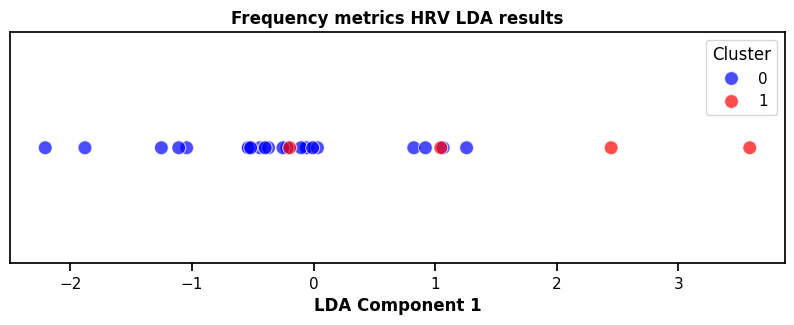

Explained variance ratio:  [1.]
Intercept:  [9.06729449]
Priors [0.84615385 0.15384615]


,Columns,LDA Coef,Means
0,S,11.32,0.36
1,SD1,-3.82,0.49
2,SD2,-12.52,0.51
3,SD1÷SD2,-8.48,0.59
4,ApEn,19.41,0.63
5,SampEn,-23.57,0.58
6,DFA α1,-12.19,0.29
7,DFA α2,4.27,0.34


In [117]:
lda_df, lda = perform_lda(median_pivot, dpn, non_linear_metrics)
plot_lda_results(lda_df, dpn, "Frequency metrics HRV LDA results")
show_lda_stats(lda, non_linear_metrics)

### LDA Man whitney >0.10

In [ ]:
col = 

lda_df, lda = perform_lda(median_pivot, dpn, col)
plot_lda_results(lda_df, dpn, "Frequency metrics HRV LDA results")
show_lda_stats(lda, col)

# LDA for whole data

<class 'pandas.core.frame.DataFrame'>
Index: 3210 entries, 0 to 3254
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  3210 non-null   int64  
 1   DPN                 3210 non-null   bool   
 2   SDRR                3210 non-null   float64
 3   RMSSD               3210 non-null   float64
 4   pNN50 (%)           3210 non-null   float64
 5   Mean HR (bpm)       3210 non-null   float64
 6   VLF Power           3210 non-null   float64
 7   VLF Peak Frequency  3210 non-null   float64
 8   LF Power            3210 non-null   float64
 9   LF Peak Frequency   3210 non-null   float64
 10  HF Power            3210 non-null   float64
 11  HF Peak Frequency   3210 non-null   float64
 12  LF÷HF Ratio         3210 non-null   float64
 13  S                   3210 non-null   float64
 14  SD1                 3210 non-null   float64
 15  SD2                 3210 non-null   float64
 16  SD1÷SD2    

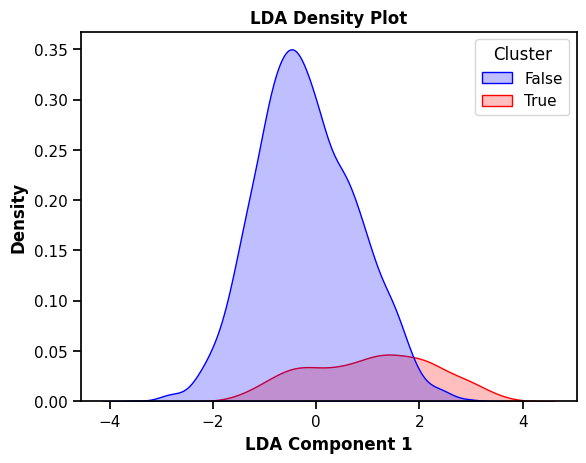

In [76]:

broad_lda = perform_lda(data[indicator_columns], data.DPN, 1)
sns.kdeplot(data=broad_lda, x=0, hue='Cluster', fill=True, common_norm=True, palette=cluster_colors)
plt.title('LDA Density Plot')
plt.xlabel('LDA Component 1')
plt.show()